In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

In [ ]:
# read in anndata object for dynamic analysis

In [3]:
adata = sc.read_h5ad('/chg3/analysts/gd2/scVelo_Oligos_Only/FemaleLow/FLOligos_Use_This_For_scVeloAnalysis.h5ad')

In [ ]:
# take a look at anndata object

In [4]:
adata

AnnData object with n_obs × n_vars = 1066 × 24039
    obs: 'nCount_RNA', 'nFeature_RNA', 'nCount_SCT', 'nFeature_SCT', 'orig.ident', 'type', 'percent.mt', 'percent.rb', 'RNA_snn_res.0.1', 'seurat_clusters', 'pANN_0.25_0.005_44', 'doublet_finder', 'pANN_0.25_0.19_1663', 'pANN_0.25_0.19_1429', 'pANN_0.25_0.24_1620', 'integrated_snn_res.1', 'monaco', 'barcode', 'UMAP_1', 'UMAP_2', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [ ]:
# pre-process the data

In [5]:
scv.pp.filter_and_normalize(adata)
scv.pp.moments(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [ ]:
# run the dynamical model

In [6]:
scv.tl.recover_dynamics(adata)

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


recovering dynamics (using 1/24 cores)


  0%|          | 0/1638 [00:00<?, ?gene/s]

    finished (0:07:46) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [7]:
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/24 cores)


  0%|          | 0/1066 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [8]:
# save the anndata object that has run through the dynamical model

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
adata.write('/chg3/analysts/gd2/scVelo_Oligos_Only/FemaleLow/FLOligos_Through_Dynamic_scVelo_Analysis.h5ad')

In [ ]:
# view velocity as an embedding stream

In [ ]:
scv.pl.velocity_embedding_stream(adata, basis='umap', color = 'monaco2')

In [ ]:
# look at rates of RNA transcription, splicing, and degradation

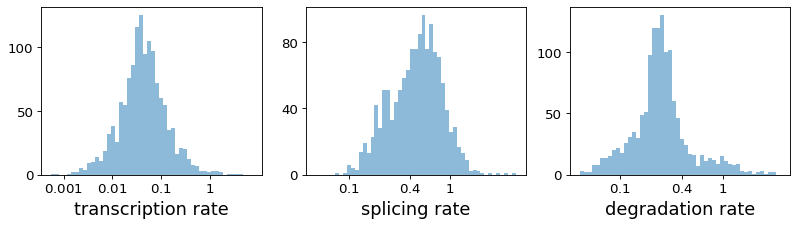

,fit_r2,fit_alpha,fit_beta,fit_gamma,fit_t_,fit_scaling,fit_std_u,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling
Rgs20,0.098943,0.020088,0.047459,0.205472,10.927877,9.050049,0.192679,0.019516,0.323298,0.0,0.0,0.005997,0.413039,0.057435,0.486245,2.240966
Oprk1,0.014923,0.015964,2.233252,1.066328,8.026405,0.245043,0.001302,0.002392,0.231807,0.0,0.0,0.000005,0.005716,0.010497,0.258960,0.937799
St18,0.020768,0.013382,0.002594,0.065837,22.809150,52.698606,1.004475,0.031450,0.304671,0.0,0.0,0.001573,4.228918,0.089966,0.384235,12.069632
Sntg1,0.750034,0.057061,0.030112,0.271029,5.454266,14.443437,0.753612,0.044133,0.402101,0.0,0.0,0.005047,1.749543,0.100847,0.343121,1.852209
Vxn,0.802502,0.282415,1.121259,0.416461,10.562167,0.215374,0.072192,0.158380,0.307225,0.0,0.0,0.141033,0.186449,0.494305,0.571611,1.898366


In [9]:
df = adata.var
df = df[(df['fit_likelihood'] > .1) & df['velocity_genes'] == True]

kwargs = dict(xscale='log', fontsize=16)
with scv.GridSpec(ncols=3) as pl:
    pl.hist(df['fit_alpha'], xlabel='transcription rate', **kwargs)
    pl.hist(df['fit_beta'] * df['fit_scaling'], xlabel='splicing rate', xticks=[.1, .4, 1], **kwargs)
    pl.hist(df['fit_gamma'], xlabel='degradation rate', xticks=[.1, .4, 1], **kwargs)

scv.get_df(adata, 'fit*', dropna=True).head()

In [ ]:
# save results as a csv file

In [ ]:
df = pd.DataFrame(df)
df.to_csv('/chg3/analysts/gd2/scVelo_Oligos_Only/FemaleLow/FLOligoKineticDynamicGenes.csv')

In [ ]:
# look at latent time or real time experienced by cells as they differentiate

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:07) --> added 
    'latent_time', shared time (adata.obs)


/usr/local/python/lib/python3.9/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


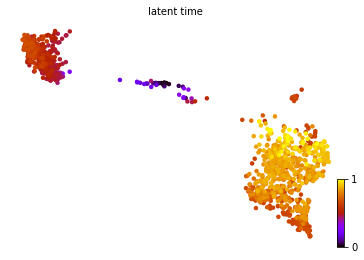

In [10]:
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [ ]:
# look at latent time via heatmap

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


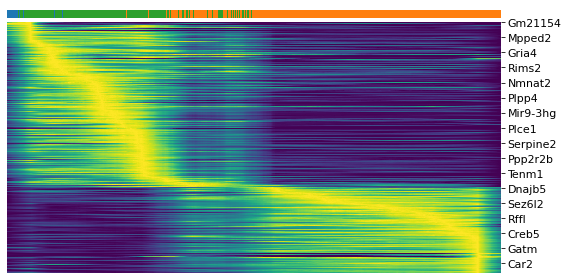

In [11]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index[:300]
scv.pl.heatmap(adata, var_names=top_genes, sortby='latent_time', col_color='monaco', n_convolve=100)

In [ ]:
# look at driver genes detected in the dynamic model

In [ ]:
top_genes = adata.var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(adata, basis=top_genes[:15], ncols=5, frameon=False)

In [ ]:
# look at specific driver genes

In [ ]:
var_names = ['Plp1', 'Mag', 'Mog', 'Pdgfra']
scv.pl.scatter(adata, var_names, frameon=False)
scv.pl.scatter(adata, x='latent_time', y=var_names, frameon=False)

In [ ]:
# look at adata.obs which is annotation of cells/observations and genes

In [12]:
adata.obs

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,nCount_RNA,nFeature_RNA,nCount_SCT,nFeature_SCT,orig.ident,type,percent.mt,percent.rb,RNA_snn_res.0.1,seurat_clusters,...,UMAP_2,initial_size_unspliced,initial_size_spliced,initial_size,n_counts,velocity_self_transition,root_cells,end_points,velocity_pseudotime,latent_time
barcode,,,,,,,,,,,,,,,,,,,,,
AAACCCATCTTTCGAT-1_1,2090,1261,4494,1512,P4AMY,Female_Low,0.813397,1.387560,5,12,...,-14.239939,990,661,661.0,2156.643066,0.177255,1.475084e-06,0.395862,0.787325,0.848430
AAACGCTCACTTCCTG-1_1,2730,1472,4579,1610,P4AMY,Female_Low,0.293040,1.318681,5,12,...,-14.283893,1384,833,833.0,2244.006348,0.465022,4.958673e-08,0.376374,0.994691,0.927849
AAAGGATTCTGTTGGA-1_1,16174,5082,6248,3816,P4AMY,Female_Low,0.191618,0.389418,7,37,...,-12.964581,9728,3093,3093.0,3590.908691,0.409173,8.066201e-01,0.052067,0.014248,0.166555
AAAGGGCCAATTCTCT-1_1,1356,898,4267,1396,P4AMY,Female_Low,0.663228,2.284451,5,12,...,-14.393990,648,431,431.0,2161.317627,0.067565,2.157524e-07,0.011886,0.508967,0.833184
AAAGGGCGTTTGAACC-1_1,1989,1206,4436,1487,P4AMY,Female_Low,0.904977,1.005530,5,12,...,-14.378398,867,695,695.0,1950.018799,0.440035,1.603940e-07,0.563040,0.984220,0.893059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCCTCTCGAGGCAA-1_1,1468,913,4341,1362,P4AMY,Female_Low,1.361470,1.974132,5,12,...,-14.752212,574,564,564.0,1778.695068,0.040046,1.367275e-06,0.004188,0.465838,0.804903
TTTCGATCACATAACC-1_1,1246,865,4221,1404,P4AMY,Female_Low,4.975923,2.166934,5,12,...,-15.652093,429,506,506.0,1677.565308,0.062777,3.454688e-07,0.000008,0.359130,0.639052
TTTGACTCAGCACCCA-1_1,2771,1427,4596,1563,P4AMY,Female_Low,0.324792,0.938289,5,12,...,-14.175445,1331,829,829.0,2294.727051,0.331762,1.472050e-08,0.562024,0.998190,0.900872


In [ ]:
# save adata.obs as a csv file

In [ ]:
df =scv.DataFrame(adata.obs)
df.head()
df = pd.DataFrame(df)
df.to_csv('/chg3/analysts/gd2/New_scVelo/FemaleLowAll_scVelo/FLAll_AdataObs.csv')

In [ ]:
# look at adata.var which are the variables

In [13]:
adata.var

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Accession,Chromosome,End,Start,Strand,gene_count_corr,fit_r2,fit_alpha,fit_beta,fit_gamma,...,fit_std_s,fit_likelihood,fit_u0,fit_s0,fit_pval_steady,fit_steady_u,fit_steady_s,fit_variance,fit_alignment_scaling,velocity_genes
Xkr4,ENSMUSG00000051951.5,1,3671498,3205901,-,0.4769,-4.150455,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Gm1992,ENSMUSG00000089699.1,1,3513553,3466587,+,0.2226,-2.872535,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Gm19938,ENSMUSG00000102331.1,1,3658904,3647309,-,0.1702,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Gm37381,ENSMUSG00000102343.1,1,3986215,3905739,-,-0.0049,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Rp1,ENSMUSG00000025900.13,1,4409241,3999557,-,-0.0122,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cyp17a1,ENSMUSG00000003555.8,19,46673172,46667165,-,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Cd40lg,ENSMUSG00000031132.1,X,57224042,57212143,+,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4933403O08Rik,ENSMUSG00000079460.11,X,112243852,112239049,+,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
Tex13b,ENSMUSG00000042386.7,X,140813433,140808307,-,NaN,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [ ]:
# save adata.var as csv file

In [ ]:
df =scv.DataFrame(adata.var)
df.head()
df = pd.DataFrame(df)
df.to_csv('/chg3/analysts/gd2/scVelo_Oligos_Only/FemaleLow/FLOligos_AdataVar.csv')

In [ ]:
# look at adata.layers which are spliced and unspllice counts and other data

In [14]:
adata.layers

/usr/local/python/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Layers with keys: ambiguous, matrix, spliced, unspliced, Ms, Mu, fit_t, fit_tau, fit_tau_, velocity, velocity_u

In [ ]:
# look at cluster-specific top-likelihood genes

In [ ]:
scv.tl.rank_dynamical_genes(adata, groupby='monaco')
df = scv.get_df(adata, 'rank_dynamical_genes/names')
df.head(5)

In [ ]:
# show specific clusters as scatter plots

In [ ]:
for cluster in ['Micro', 'Astrocyte', 'Mature Oligo', 'OPC']:
    scv.pl.scatter(adata, df[cluster][:5], ylabel=monaco, frameon=False)